# Enseñando a las computadoras lenguaje natural

In [ ]:
# Setup
# This cell installs all the dependencies used in this week - imports happen as we go
%%capture
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('word2vec_sample')
!pip install datasets

In [ ]:
import torch

## Neural NLP


Los modelos de la notebook anterior funcionaron bien y podríamos seguir probando modelos más complejos como el aumento de gradiente, pero eventualmente tenemos que aceptar que actualmente estamos ignorando el **contexto** y **significado** de las palabras utilizadas en su totalidad.

¿Qué pasaría si pudiéramos agregar una pista a nuestros vectores de palabras sobre dónde se usa una palabra o en qué contexto? Pero, ¿cómo expresaríamos tal información y cómo la calcularíamos?


---


*You shall know a word by the company it keeps (J.R. Firth 1957)*

El significado de las palabras está definido por las palabras en su contexto.

## Embedding de palabras (word2vec)

El lenguaje natural es un sistema complejo utilizado para expresar significados.
En este sistema, las palabras son la unidad básica del significado. Como su nombre lo indica, los *vectores de palabras* son vectores que se utilizan para representar palabras y también se pueden considerar como vectores de características o representaciones de palabras. La técnica de mapear palabras a vectores reales se llama **Embedding de palabras**. En los últimos años, los embedding de palabras se han convertido gradualmente en el conocimiento básico del procesamiento del lenguaje natural.





En 2013, investigadores de Google publicaron una idea que cambió nuestra comprensión de las palabras y utiliza directamente la idea propuesta anteriormente: el lugar en el espacio vectorial donde se debe colocar una palabra está definido por las palabras que normalmente la rodean. En lugar de una única dimensión por palabra como en la codificación one-hot, hay dimensiones compartidas para todas las palabras y su posición se puede utilizar para inferir su significado.

Un espacio así sería difícil de crear a mano y, en cambio, se aprende a partir de un corpus. Veamos cómo...

[Click here to access the paper on arxiv.org.](https://arxiv.org/abs/1301.3781)

Un *embedding* es una representación vectorial de nuestros datos en un espacio de dimensión **relativamente bajo**. La representación mediante *embeddings* suele utilizarse para facilitar el aprendizaje de modelos cuando se tienen que manejar datos categóricos o conceptos cuya codificación suele llevar a representaciones *sparse* de alta dimensión, como pueden ser codificaciones one-hot encoding de variables categóricas estandar o  representaciones BoW o TF-IDF de documentos.

## Los vectores One-Hot son una mala elección

Hasta ahora hemos usado vectores one-hot para representar palabras. Suponga que el número de palabras diferentes en el diccionario (el tamaño del diccionario) es $N$, y cada palabra corresponde a un número entero diferente (índice) de $0$ a $N-1$. Para obtener la representación vectorial one-hot para cualquier palabra con índice $i$, creamos un vector de longitud $N$ con todos 0 y establecemos el elemento en la posición $i$ a 1. De esta manera, cada palabra se representa como un vector de longitud $N$, y puede ser utilizado directamente por redes neuronales.


<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/OneHotEncoding.png" width="40%">




Aunque los vectores one-hot son fáciles de construir, por lo general no son una buena opción. Las principales razones son:
* **Ineficiencia**: El tamaño de cada vector depende del tamaño del vocabulario. Dado que los vocabularios contienen varios cientos de miles de palabras, estos vectores ocupan mucho espacio y están mayormente compuestos de ceros.
* **Ortogonalidad**: Cualquier par de vectores one-hot es ortogonal, por lo tanto no hay una noción natural de similaridad entre ellos.


Por un lado, trabajar con un espacio de muy alta dimensión implica entrenar un modelo con muchos parámetros, lo que a su vez conlleva un mayor coste computacional, riesgo de sobreajuste, ...

Por otro lado, el tener que manejar representaciones dispersas dificulta el cálculo de distancias entre elementos así como la identificación de elementos similares. Por ejemplo, la codificación anterior nos va a dar la misma distancia entre Rome y Paris que entre Rome e Italia.

Por tanto, para utilizar este tipo de representaciones en un sistema de aprendizaje automático, necesitamos una forma de representar cada vector disperso como un vector de números para el que los elementos semánticamente similares (ciudades, películas o palabras) tengan distancias similares en el espacio vectorial. La solución a estos problemas es utilizar embeddings, ya que son capaces de transformar grandes vectores dispersos a un espacio de menor dimensión que preserva las relaciones semánticas.

Idealmente, un buen *embedding* debe proporcionar un conjunto de vectores cuya posición (distancia y dirección) en el espacio vectorial codifique la semántica de los datos que representan. Las siguientes visualizaciones$^{(*)}$ de *embeddings* reales muestran relaciones geométricas que capturan relaciones semánticas como el genero, un tiempo verbal o la relación entre un país y su capital

<img src="http://www.tsc.uc3m.es/~vanessa/Figs_notebooks/BBVA/Embeddings/Embeddings1.svg" width="80%">

Además, la representación de los datos mediante  *embeddings* tiene varias ventajas:
* Ayuda al aprendizaje del modelo, ya que reducirá el coste computacional y evitará problemas de sobreajuste.  
* Esta representación puede aprenderse y reutilizarse en distintos modelos.
* Al manejar los datos en un espacio de menor dimensión se facilita su representación, ya sea porque el *embedding* nos permite tener los datos en un espacio de dos o tres dimensiones, o porque se puede combinar con algoritmos de visualización  que nos permiten visualizar lo que está ocurriendo en este espacio del *embedding*.

$^{(*)}$ https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space


## Ejemplo inspirador: Embedding de personalidad

En una escala de 0 a 100, ¿qué tan introvertido/extrovertido eres (donde 0 es el más introvertido y 100 es el más extrovertido)? ¿Alguna vez has realizado una prueba de personalidad como la prueba de los Cinco Grandes Rasgos de la Personalidad? Si no lo has hecho, estas son pruebas que te hacen una lista de preguntas, y luego te califican en una serie de ejes, siendo la introversión/extraversión uno de ellos.

Imaginemos que Jay obtuvo una puntuación de 38/100 en el rasgo introversión/extraversión. Podemos graficar eso de esta manera:
![](http://jalammar.github.io/images/word2vec/introversion-extraversion-100.png)

Supongamos que, además de ese, también contemplamos otro de los 5 rasgos y que las escalas de 0 a 100 son reemplazadas por una escala de -1 a 1. Así obtendríamos un vector que represente a Jay de la siguiente manera:

![](http://jalammar.github.io/images/word2vec/two-traits-vector.png)

Ahora podemos decir que este vector representa parcialmente la personalidad de Jay. La utilidad de tal representación viene cuando compararlo con otras dos personas. Digamos que se va y necesita ser reemplazado por alguien con una personalidad similar. En la siguiente figura, ¿cuál de las dos personas se parece más a Jay?

![](http://jalammar.github.io/images/word2vec/personality-two-persons.png)

Podemos ver que la persona n° 1 es más parecida a Jay porque gráficamente su vector está más "cerca" al de Jay. Ahora supongamos que tenemos un vector con los 5 rasgos... el análisis gráfico no es una opción. Sin embargo, podemos calcular la similaridad a través del ángulo entre los vectores (que se calcula utilizando el coseno como ya vimos) para obtener una métrica que facilite la comparación.

![](http://jalammar.github.io/images/word2vec/embeddings-cosine-personality.png)

Seguimos viendo que la persona más parecida es la n°1, pero ahora tenemos una métrica para saber cuán mejor reemplazo es con respecto a la otra persona. En los ejercicios asociados a esta clase se puede jugar con un dataset que contiene los vectores asociados a personas reales para ver la utilidad práctica de este concepto.



## Embedding de palabras: ¿Cómo codificamos el significado?

Para que las palabras sean procesadas por modelos de aprendizaje automático, necesitan alguna forma de representación numérica que los modelos puedan usar en sus cálculos. Ahora que entendemos el poder de representación de los vectores, podemos proceder a observar ejemplos de vectores de palabras entrenados (también llamados embeddings de palabras) y comenzar a observar algunas de sus propiedades interesantes.

Word2Vec fue el primer algoritmo en demostrar que podemos usar un vector para representar correctamente las palabras de una manera que capturara las relaciones semánticas o de significado. Por ejemplo, al analizar estos vectores podemos saber si las palabras son similares u opuestas (analizando la dirección y el sentido del vector), o que un par de palabras como “Estocolmo” y “Suecia” tienen entre ellas la misma relación que tienen “El Cairo” y “Egipto” (analizando las distancias entre los vectores), o también relaciones sintácticas o basadas en la gramática (por ejemplo, la relación entre “tenía” y “tengo” es la misma que entre “era” y “es”).

Este es un embedding para la palabra "rey" (vector GloVe entrenado en Wikipedia):

$$[ 0.50451 , 0.68607 , -0.59517 , -0.022801, 0.60046 , -0.13498 , -0.08813 , 0.47377 , -0.61798 , -0.31012 , -0.076666, 1.493 , -0.034189, -0.98173 , 0.68229 , 0.81722 , -0.51874 , -0.31503 , -0.55809 , 0.66421 , 0.1961 , -0.13495 , -0.11476 , -0.30344 , 0.41177 , -2.223 , -1.0756 , -1.0783 , -0.34354 , 0.33505 , 1.9927 , -0.04234 , -0.64319 , 0.71125 , 0.49159 , 0.16754 , 0.34344 , -0.25663 , -0.8523 , 0.1661 , 0.40102 , 1.1685 , -1.0137 , -0.21585 , -0.15155 , 0.78321 , -0.91241 , -1.6106 , -0.64426 , -0.51042 ] $$



Es una lista de 50 números. No podemos decir mucho mirando los valores. Pero visualicémoslo un poco para poder compararlo con otros vectores de palabras. Pongamos todos estos números en una fila y codifiquemos por colores las celdas según sus valores (rojo si están cerca de 2, blanco si están cerca de 0, azul si están cerca de -2):

![](http://jalammar.github.io/images/word2vec/king-colored-embedding.png)

Procederemos ignorando los números y solo observando los colores para indicar los valores de las celdas. Ahora comparemos "Rey" con otras palabras:

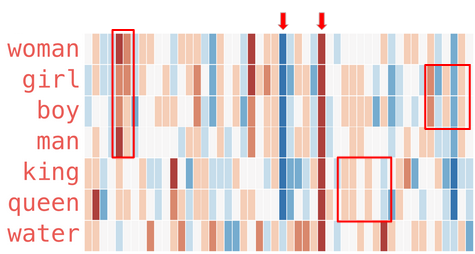

Algunas cosas para señalar:

* Hay una columna roja recta a través de todas estas palabras diferentes. Son similares a lo largo de esa dimensión (y no sabemos qué codifica cada dimensión)
* Puedes ver cómo "mujer" y "niña" son similares entre sí en muchos lugares. Lo mismo con "hombre" y "niño"
* “niño” y “niña” también tienen lugares donde son similares entre sí, pero diferentes de “mujer” u “hombre”. ¿Podrían estar codificando una vaga concepción de la juventud?
* Todas menos la última palabra son palabras que representan personas. Podemos, por ejemplo, ver que la columna azul va hacia abajo y se detiene antes del embedding de "agua".
* Hay lugares claros donde "rey" y "reina" son similares entre sí y distintos de todos los demás. ¿Podrían estar codificando un concepto vago de realeza?



Otro ejemplo más que prueba lo poderosos que son estos embeddings es el concepto de las analogías. Podemos sumar y restar embeddings de palabras y llegar a resultados interesantes. El ejemplo más famoso es la fórmula: "rey" - "hombre" + "mujer":

![](http://jalammar.github.io/images/word2vec/king-analogy-viz.png)

El vector resultante de "rey-hombre+mujer" no es exactamente igual a "reina", pero "reina" es la palabra más cercana de los 400 000 embeddings de palabras que tenemos en esta colección.

Algo importante que debe quedar claro es que, en contraste con los embeddings de personalidad que analizamos anteriormente, ***no sabemos que codifica cada dimensión del vector***. Podemos hacer conjeturas y experimentos que nos permitan validar que estos vectores están modelando de alguna u otra forma la semántica, pero esta codificación de los datos es la que a la red le pareció la más eficiente durante el entrenamiento.

#Usando Embeddings Preentrenados: GloVe

In [ ]:
!pip install --upgrade --force-reinstall numpy==1.23.5 scipy==1.9.3 gensim==4.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.4/33.4 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled smart-open-7.1.0
  Attempting uninstall: scipy
    Found existing installatio

1. Cargar modelo GloVe y visualizar

In [ ]:
import gensim.downloader
model = gensim.downloader.load('glove-wiki-gigaword-50')  # o glove-twitter-200
model["love"], model["love"].shape


[==================================================] 100.0% 66.0/66.0MB downloaded


(array([-0.13886  ,  1.1401   , -0.85212  , -0.29212  ,  0.75534  ,
         0.82762  , -0.3181   ,  0.0072204, -0.34762  ,  1.0731   ,
        -0.24665  ,  0.97765  , -0.55835  , -0.090318 ,  0.83182  ,
        -0.33317  ,  0.22648  ,  0.30913  ,  0.026929 , -0.086739 ,
        -0.14703  ,  1.3543   ,  0.53695  ,  0.43735  ,  1.2749   ,
        -1.4382   , -1.2815   , -0.15196  ,  1.0506   , -0.93644  ,
         2.7561   ,  0.58967  , -0.29473  ,  0.27574  , -0.32928  ,
        -0.201    , -0.28547  , -0.45987  , -0.14603  , -0.69372  ,
         0.070761 , -0.19326  , -0.1855   , -0.16095  ,  0.24268  ,
         0.20784  ,  0.030924 , -1.3711   , -0.28606  ,  0.2898   ],
       dtype=float32),
 (50,))

2. Visualización PCA

<Axes: >

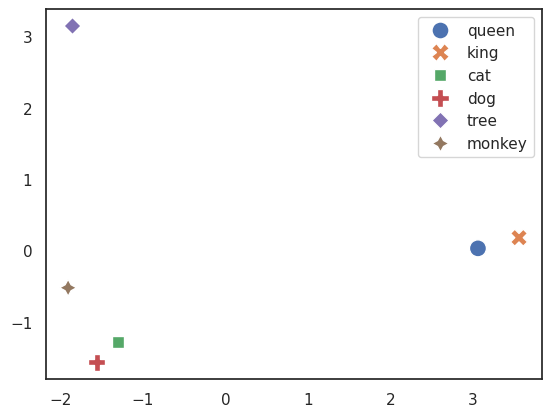

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

words = ["queen", "king", "cat", "dog", "tree", "monkey"]
vectors = np.vstack([model[word] for word in words])
reduced = PCA(n_components=2).fit_transform(vectors)

sns.set(style='white', context='notebook')
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], s=150, hue=words, style=words)


3.Visualización de embeddings promediados de tweets

In [ ]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
nltk.download('all')

stopwords_en = set(stopwords.words("english")).union(set(punctuation))
wnl = WordNetLemmatizer()

def penn2morphy(tag):
    return {"NN": "n", "JJ": "a", "VB": "v", "RB": "r"}.get(tag[:2], "n")

def preprocess(text):
    return [wnl.lemmatize(w.lower(), pos=penn2morphy(t))
            for w, t in pos_tag(word_tokenize(text))
            if w.lower() not in stopwords_en and w.isalpha()]

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

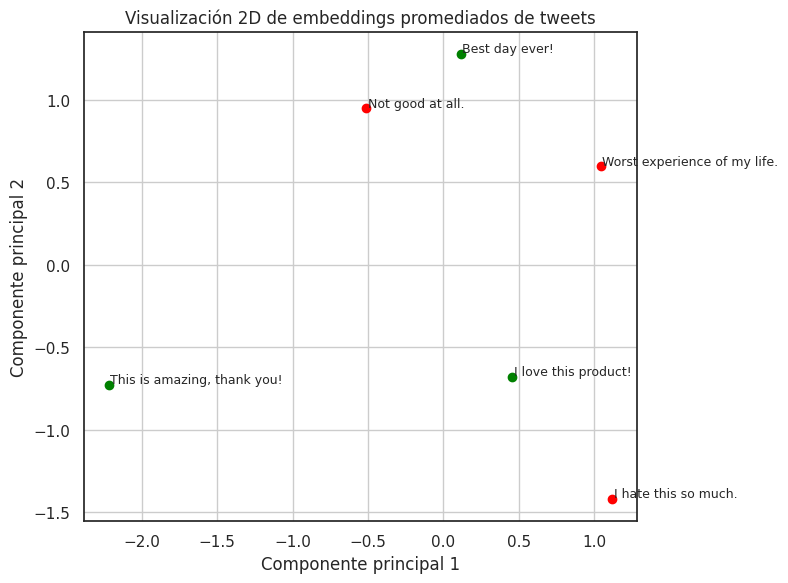

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Frases de ejemplo con sentimiento (1 = positivo, 0 = negativo)
tweets = [
    ("I love this product!", 1),
    ("This is amazing, thank you!", 1),
    ("Best day ever!", 1),
    ("I hate this so much.", 0),
    ("Worst experience of my life.", 0),
    ("Not good at all.", 0)
]

# Función para obtener el embedding promedio de un tweet
def embed_example(text, model, preprocess_fn, dim=50):
    tokens = preprocess_fn(text)
    vectors = [model[w] for w in tokens if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

# Embeddings y etiquetas
embeddings = np.array([embed_example(t[0], model, preprocess, dim=50) for t in tweets])
labels = np.array([t[1] for t in tweets])
texts = [t[0] for t in tweets]

# Reducir dimensión con PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(embeddings)

# Visualización
plt.figure(figsize=(8, 6))
colors = ['red' if label == 0 else 'green' for label in labels]
for i, (x, y) in enumerate(proj):
    plt.scatter(x, y, color=colors[i])
    plt.text(x + 0.01, y + 0.01, texts[i], fontsize=9)

plt.title("Visualización 2D de embeddings promediados de tweets")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


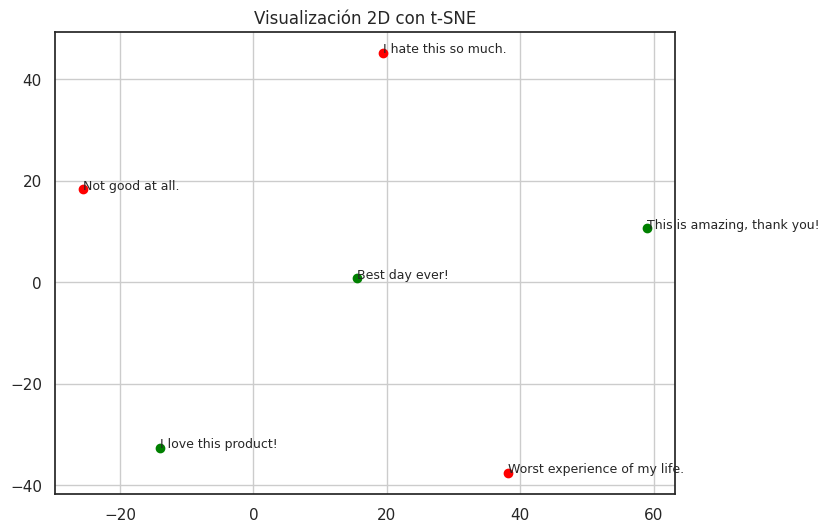

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
proj_tsne = tsne.fit_transform(embeddings)

# Visualizar igual que antes
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(proj_tsne):
    plt.scatter(x, y, color=colors[i])
    plt.text(x + 0.01, y + 0.01, texts[i], fontsize=9)
plt.title("Visualización 2D con t-SNE")
plt.grid(True)
plt.show()


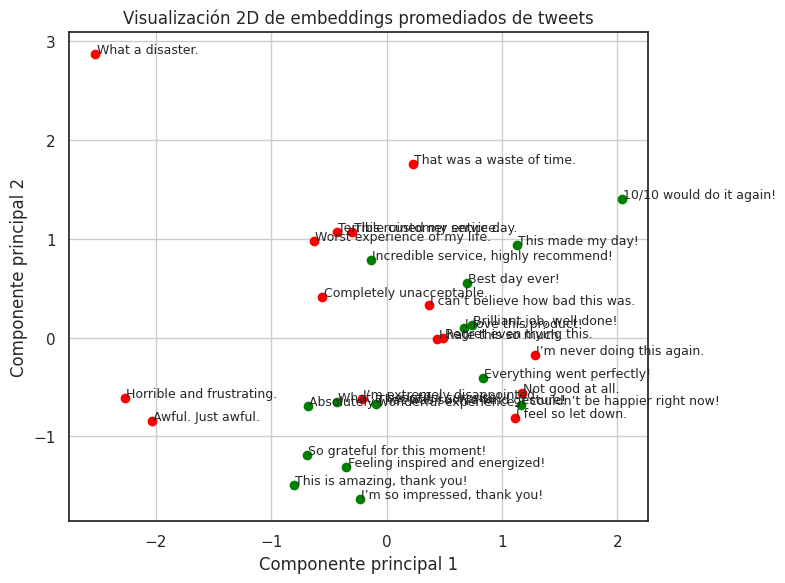

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Frases de ejemplo con sentimiento (1 = positivo, 0 = negativo)
tweets = [
    ("I love this product!", 1),
    ("This is amazing, thank you!", 1),
    ("Best day ever!", 1),
    ("Absolutely wonderful experience.", 1),
    ("I couldn’t be happier right now!", 1),
    ("So grateful for this moment!", 1),
    ("That was such a kind gesture!", 1),
    ("Incredible service, highly recommend!", 1),
    ("Everything went perfectly!", 1),
    ("What a beautiful surprise!", 1),
    ("I’m so impressed, thank you!", 1),
    ("Brilliant job, well done!", 1),
    ("Feeling inspired and energized!", 1),
    ("This made my day!", 1),
    ("10/10 would do it again!", 1),
  ("I hate this so much.", 0),
    ("Worst experience of my life.", 0),
    ("Not good at all.", 0),
    ("I’m extremely disappointed.", 0),
    ("Terrible customer service.", 0),
    ("That was a waste of time.", 0),
    ("Completely unacceptable.", 0),
    ("I’m never doing this again.", 0),
    ("Horrible and frustrating.", 0),
    ("What a disaster.", 0),
    ("I can’t believe how bad this was.", 0),
    ("Awful. Just awful.", 0),
    ("I feel so let down.", 0),
    ("This ruined my entire day.", 0),
    ("Regret even trying this.", 0)
]

# Función para obtener el embedding promedio de un tweet
def embed_example(text, model, preprocess_fn, dim=50):
    tokens = preprocess_fn(text)
    vectors = [model[w] for w in tokens if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

# Embeddings y etiquetas
embeddings = np.array([embed_example(t[0], model, preprocess, dim=50) for t in tweets])
labels = np.array([t[1] for t in tweets])
texts = [t[0] for t in tweets]

# Reducir dimensión con PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(embeddings)

# Visualización
plt.figure(figsize=(8, 6))
colors = ['red' if label == 0 else 'green' for label in labels]
for i, (x, y) in enumerate(proj):
    plt.scatter(x, y, color=colors[i])
    plt.text(x + 0.01, y + 0.01, texts[i], fontsize=9)

plt.title("Visualización 2D de embeddings promediados de tweets")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()


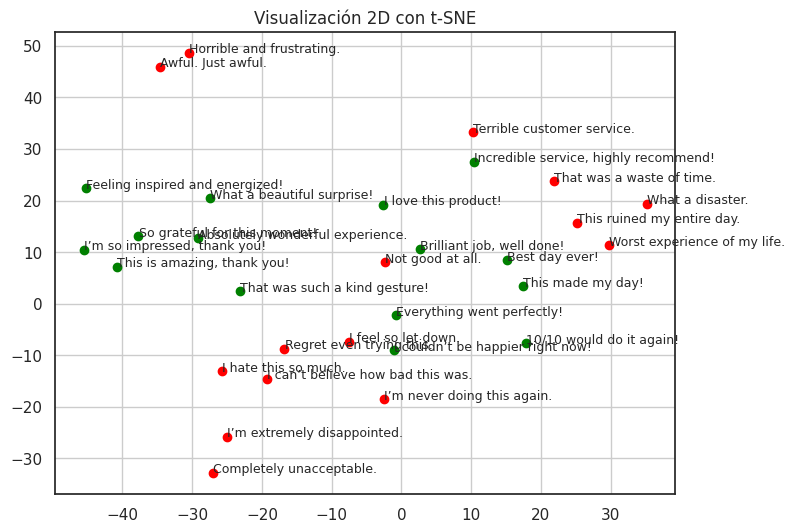

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
proj_tsne = tsne.fit_transform(embeddings)

# Visualizar igual que antes
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(proj_tsne):
    plt.scatter(x, y, color=colors[i])
    plt.text(x + 0.01, y + 0.01, texts[i], fontsize=9)
plt.title("Visualización 2D con t-SNE")
plt.grid(True)
plt.show()
